In [12]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [13]:
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [14]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = True

Current Working Directory: progettoVIPM


In [15]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset

In [16]:
model = models.resnet50()
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("C:\\Users\\marco\\Desktop\\Uni\\Magistrale\\VIPM\\Progetto\\resnet50model.pth")['model_state'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
num_classes = 251
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
from torch.utils.data import DataLoader, ConcatDataset, random_split


trainL = ImageDataset(datasets.TRAINING_LABELED_80, 224, cuda=True)
trainU = ImageDataset(datasets.ASSIGNED_LABELS_10,224,cuda=True)
trainC = ConcatDataset([trainL,trainU])
val = ImageDataset(datasets.VALIDATION_LABELED_20, 224, cuda=True)
test = ImageDataset(datasets.TEST, 224, cuda=True)

trainC = DataLoader(trainC, batch_size=128, shuffle=True)
valL = DataLoader(val, batch_size=128, shuffle=False)
test = DataLoader(test, batch_size=128, shuffle=False)



In [9]:
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the last layer
for param in model.fc.parameters():
    param.requires_grad = True

In [20]:

train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 10
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
best_model_path = 'Transfer_Learning/models/best_Label_Extended_FineTuned_ResNet50.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainC:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainC)}')
        labels = [int(label) for label in labels]
        
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainC)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainC))
    print('Validation:')
    model.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            labels=[int(lable) for lable in labels]
            
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = model(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:
Batch 10 di 49
Batch 20 di 49
Batch 30 di 49
Batch 40 di 49
Training Loss: 5.454824895274882, Accuracy: 1.0677883837566737%
Validation:
Validation Loss: 5.310419976711273, Accuracy: 3.2868525896414345%
Best model saved with validation loss: 5.310419976711273
Epoch: 2
Training:
Batch 10 di 49
Batch 20 di 49
Batch 30 di 49
Batch 40 di 49
Training Loss: 4.902071485714036, Accuracy: 9.820417408186378%
Validation:
Validation Loss: 4.742262125015259, Accuracy: 15.936254980079681%
Best model saved with validation loss: 4.742262125015259
Epoch: 3
Training:
Batch 10 di 49
Batch 20 di 49
Batch 30 di 49
Batch 40 di 49
Training Loss: 4.290025346133174, Accuracy: 21.857304643261607%
Validation:
Validation Loss: 4.308932542800903, Accuracy: 22.111553784860558%
Best model saved with validation loss: 4.308932542800903
Epoch: 4
Training:
Batch 10 di 49
Batch 20 di 49
Batch 30 di 49
Batch 40 di 49
Training Loss: 3.690062936471433, Accuracy: 35.72237502022327%
Validation:
Validation Lo

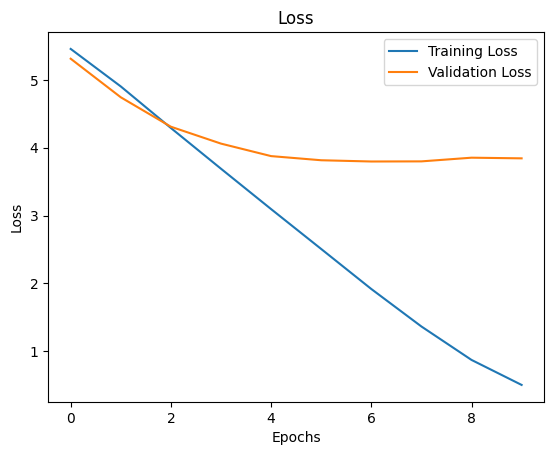

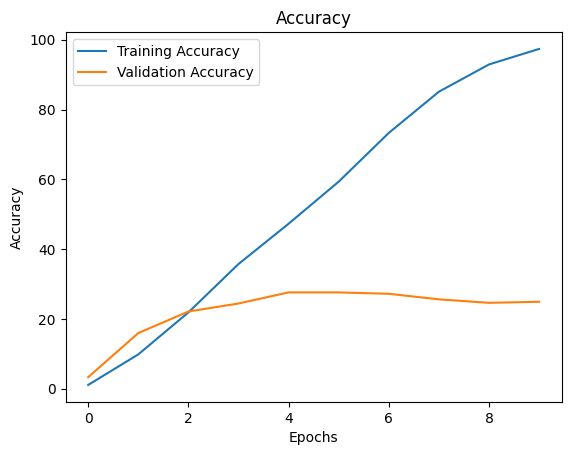

In [21]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)
plot_accuracy(train_acc,val_acc)